# Precession from Tides

This implementation adds precession from the tidal interactions between a primary body and all other bodies in the simulation.  It includes tides raised on the primary as well as on the other bodies.  

In all cases, we need to set masses for all the particles that will feel these tidal forces.  After that, we can choose to include tides raised on the primary, on the "planets", or both, by setting the respective bodies' `R_tides` (physical radius) and `k_1` (apsidal motion constant, half the tidal Love number $k_2$) parameters.  Note that the `R_tides` parameter can be independently set from the physical radius stored in `rebound.Particle.r`.

As an example, we'll add the tidal precession induced by tides raised on the planet.

In [7]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.) 
sim.add(m=1.e-3, a=0.1, e=0.2)
sim.add(a=5, e=0.2) # didn't give a mass.  Will not feel tidal precession.
sim.move_to_com()
ps = sim.particles

Now we add the effect, and have to set the `R_tides` and `k_1` parameters for the planet.

In [8]:
import reboundx
rebx = reboundx.Extras(sim)
tides = rebx.add("tides_precession")
ps[1].params["R_tides"] = 7.e4/1.5e8 # radius in same units of distance (here G=1, so AU)
ps[1].params["k1"] = 0.3

The implementation defaults to treating `sim.particles[0]` as the primary.  You can also set this flag explicitly (if the primary were at a different index):

In [9]:
ps[0].params["primary"] = 1

We'll integrate for 1000 years, store the two planets' pericenter positions, and keep track of the energy error (this force is conservative).  To get the full hamiltonian, we have to add the classical energy to the potential from precession.

In [10]:
import numpy as np
H0 = sim.calculate_energy() + rebx.tides_precession_hamiltonian(sim, tides)
tmax = 1000
Nout=1000

pomega1, pomega2, Eerr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0,tmax,Nout)

In [11]:
for i, time in enumerate(times):
    sim.integrate(time)
    pomega1[i] = ps[1].pomega
    pomega2[i] = ps[2].pomega
    H = sim.calculate_energy() + rebx.tides_precession_hamiltonian(sim, tides)
    Eerr[i] = abs((H-H0)/H0)

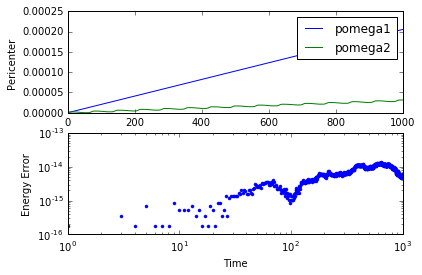

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(nrows=2)
axarr[0].plot(times, pomega1, label="pomega1")
axarr[0].plot(times, pomega2, label="pomega2")
axarr[0].set_ylabel("Pericenter")
axarr[0].legend()
axarr[1].plot(times, Eerr, '.')
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel('Energy Error')

Because we didn't set a mass of the outer planet (so it defaulted to 0), the outer body did not feel tidal precession.  Nevertheless it precesses due to the gravity of the inner body.  The inner body feels no precession from the outer test particle, but precesses due to tides raised on it by the central star.  

To turn on tides raised on the planets, we would simply set their respective `R_tides` and `k_1` parameters.